In [1]:
! pip install --quiet pymongo[srv,tls] 
! pip install --quiet pystan

In [553]:
from pymongo import MongoClient
from dateutil.parser import parse
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import mannwhitneyu, f_oneway
import os

In [3]:
client = MongoClient(os.environ.get('MONGO_HOST'), 
            username = os.environ.get('MONGO_USER'), 
                     password = os.environ.get('MONGO_PASS'))
coll = client['mab-survey'].trial

In [4]:
def get_avg_interval(boxes):
    times = [parse(b['timestamp']) for b in boxes]
    return np.mean(np.diff(times)).seconds
    
def get_spread(d): 
    boxes = d['boxes'][1]
    return parse(boxes[-1]['timestamp']) - parse(boxes[0]['timestamp'])

won = lambda b: len([i for i in b if i['result'] == 'win']) > 0

In [5]:
l = list(coll.find({ 'version': '0.5'}))

In [ ]:
from scipy.stats import beta

w = [won(i['boxes'][1]) for i in l]
t = [i['treatment']['ab'] for i in l]
time = [get_spread(d).total_seconds() for d in l]
rolls = [len(d['boxes'][1]) for d in l]
avg = [get_avg_interval(i['boxes'][1]) for i in l]

df = pd.DataFrame({
    'won': w,
    'treatment': t,
    'time': time,
    'rolls': rolls,
    'roll_time': avg
})


prize = 5
posterior = lambda n: beta.mean(1,1 + n)
c = lambda rho: lambda p: (prize**(1-rho) * p - p + 1)**(1/(1 - rho))
# c = lambda rho: lambda p: p**(1/(1-rho)) * prize
# c = lambda rho: lambda p: prize**p
# opportunity cost per second
# (5p - p + 1)/rolltime
# vs -- that +1 messes it up!
# p*5/roll_time


df['opportunity_cost'] = df.rolls.map(posterior).map(c(2.)) / df.roll_time
# df['opportunity_cost_linear'] = df.rolls.map(posterior).map(c(0)) / df.roll_time
df['opportunity_cost_linear'] = df.rolls.map(posterior) * prize / df.roll_time


df = df.assign(group = (df.treatment == 'a').astype(int) + 1)
df = df.assign(prize = prize )

(_,a),(_,b) = df[df.won == False].groupby('treatment')

d = df[df.won == False]

d

In [17]:
from pystan import StanModel

model = StanModel('../experiments/distortion-grouped.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3a2910ccf281f0a6e30a080b97437138 NOW.


In [18]:
data = {
    'penalty': 1000,
    'sd_cost_shape': 10,
    'sd_cost_scale': 1,
    'sd_epsilon_shape': 2,
    'sd_epsilon_scale': 2,
    'rho_shape': 3,
    'rho_scale': 1,
    'mean_epsilon_nu': 5,
    'mean_cost_nu': 5,
    'mean_cost_center': 0,
    'fraction': 10,
    'M': d.shape[0],
    'N': d.rolls,
    'G': d.group,
    'roll_time': d.roll_time,
    'prize': d.prize
}

In [88]:
d.to_csv('distortion.csv')

In [545]:
eps_all = pd.read_csv('eps.all.csv')
means = pd.read_csv('eps.sampled.csv')
means = means.rename(columns = {'mean_epsilon.1': 'B', 'mean_epsilon.2': 'A'})

In [546]:
mannwhitneyu(means.A, means.B)

MannwhitneyuResult(statistic=1820920.0, pvalue=0.0)

In [554]:
f_oneway(means.A, means.B)

F_onewayResult(statistic=5443.7932056721202, pvalue=0.0)

In [547]:
np.median(means.A), np.median(means.B)

(1.79712507793062, 1.152832592342695)

In [550]:
def foo(N):
    a = np.random.choice(means.A, N)
    b = np.random.choice(means.B, N)
    return ((b - a) > 0).sum()/N

foo(1000000)

0.113395

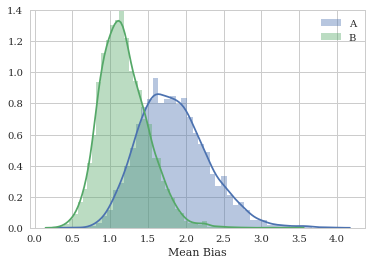

In [551]:
import matplotlib.pyplot as plt

sns.set(font = 'serif', style = 'whitegrid')
sns.distplot(means.A, label = 'A')
sns.distplot(means.B, label = 'B')
plt.xlabel('Mean Bias')
plt.legend()
plt.savefig('mean-bias.pdf')
plt.show()

In [ ]:
eps_all.drop(['Unnamed: 0'], 1).iloc[:, (d.treatment == 'a').tolist()].plot.hist(bins = 30)

In [ ]:
eps_all.drop(['Unnamed: 0'], 1).iloc[:, (d.treatment == 'b').tolist()].plot.hist(bins = 30)

In [141]:
from statsmodels.iolib.summary2 import _df_to_simpletable

In [ ]:
f = (pd
     .concat([d.groupby('treatment').median(), d.groupby('treatment').mean()])
     .reset_index()
     .assign(N = [29, 28, 29, 28])
     .drop(['group', 'prize', 'won'], 1))

f

In [ ]:
print(_df_to_simpletable(f, float_format='%.2f').as_latex_tabular())

In [460]:
t = mannwhitneyu(a.time.tolist(), b.time.tolist())
stats = [t.pvalue, t.statistic]
['{0:.3f}'.format(i) for i in stats]

['0.285', '370.000']

In [459]:
t = mannwhitneyu(a.opportunity_cost.tolist(), b.opportunity_cost.tolist())

stats = [t.pvalue, t.statistic]
['{0:.3f}'.format(i) for i in stats]

['0.000', '2.000']

In [462]:
d.shape

(57, 9)

In [461]:
t = mannwhitneyu(a.opportunity_cost_linear.tolist(), b.opportunity_cost_linear.tolist())

stats = [t.pvalue, t.statistic]
['{0:.3f}'.format(i) for i in stats]

['0.080', '317.500']

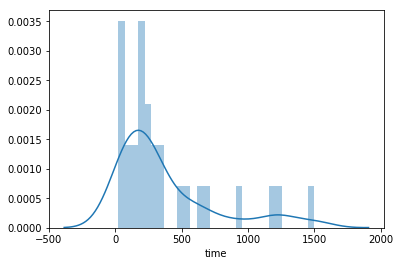

In [157]:
sns.distplot(a.time, bins=30)

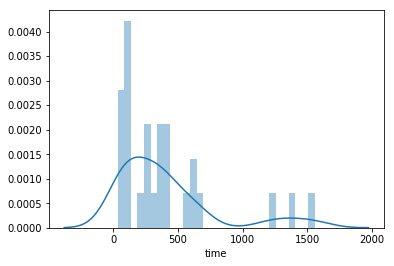

In [158]:
sns.distplot(b.time, bins=30)

In [361]:
.25/100 * 60 * 60

9.0

[(0, 0.5)]

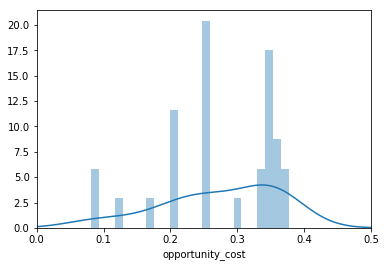

In [55]:
sns.distplot(a.opportunity_cost, bins = 25).set(xlim=(0,.5))

[(0, 0.5)]

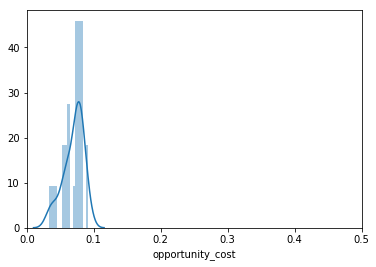

In [ ]:
sns.distplot(b.opportunity_cost, bins = 15).set(xlim=(0,.5))

[(0, 0.15)]

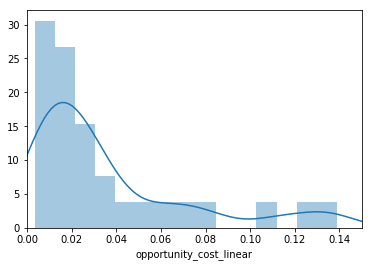

In [79]:
sns.distplot(a.opportunity_cost_linear, bins = 15).set(xlim=(0,.15))

[(0, 0.15)]

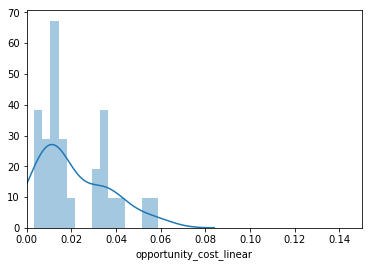

In [80]:
sns.distplot(b.opportunity_cost_linear, bins = 15).set(xlim=(0,.15))